In [1]:
# Load standard modules
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

# Load tudatpy modules
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation import environment_setup, propagation_setup
from tudatpy.kernel.astro import element_conversion
from tudatpy.kernel import constants
from tudatpy.util import result2array

In [29]:
# Load spice kernels
spice.load_standard_kernels()

# Set simulation start and end epochs
simulation_start_epoch = 0.0
simulation_end_epoch = constants.JULIAN_DAY*30

In [30]:
# Define string names for bodies to be created from default.
bodies_to_create = ["Sun", "Earth", "Moon"]

# Use "Earth"/"J2000" as global frame origin and orientation.
global_frame_origin = "Moon"
global_frame_orientation = "J2000"

# Create default body settings, usually from `spice`.
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create,
    global_frame_origin,
    global_frame_orientation)

# Create system of selected celestial bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

In [31]:
# Create vehicle objects.
bodies.create_empty_body("LunarSat")

bodies.get("LunarSat").mass = 400.0

In [32]:
# Create radiation pressure settings, and add to vehicle
reference_area_radiation = 4.0
radiation_pressure_coefficient = 1.2
occulting_bodies = ["Earth","Moon"]
radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
    "Sun", reference_area_radiation, radiation_pressure_coefficient, occulting_bodies
)
environment_setup.add_radiation_pressure_interface(
    bodies, "LunarSat", radiation_pressure_settings)

In [33]:
# Define bodies that are propagated
bodies_to_propagate = ["LunarSat"]

# Define central bodies of propagation
central_bodies = ["Moon"]

In [34]:
# Define accelerations acting on Delfi-C3 by Sun and Earth.
accelerations_settings_LunarSat = dict(
    Sun=[
        propagation_setup.acceleration.cannonball_radiation_pressure(),
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Earth=[
        propagation_setup.acceleration.spherical_harmonic_gravity(5, 5)
    ],
    Moon=[
        propagation_setup.acceleration.spherical_harmonic_gravity(5, 5)
    ]
)

# Create global accelerations settings dictionary.
acceleration_settings = {"LunarSat": accelerations_settings_LunarSat}

# Create acceleration models.
acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    bodies_to_propagate,
    central_bodies)

In [35]:
# Set initial conditions for the satellite that will be
# propagated in this simulation. The initial conditions are given in
# Keplerian elements and later on converted to Cartesian elements
moon_gravitational_parameter = bodies.get("Moon").gravitational_parameter
initial_state = element_conversion.keplerian_to_cartesian_elementwise(
    gravitational_parameter=moon_gravitational_parameter,
    semi_major_axis=3000.0e3,
    eccentricity=1,
    inclination=np.deg2rad(80),
    argument_of_periapsis=np.deg2rad(235.7),
    longitude_of_ascending_node=np.deg2rad(23.4),
    true_anomaly=np.deg2rad(139.87),
)

In [36]:
# Define list of dependent variables to save
dependent_variables_to_save = [
    propagation_setup.dependent_variable.total_acceleration("LunarSat"),
    propagation_setup.dependent_variable.keplerian_state("LunarSat", "Moon"),
    propagation_setup.dependent_variable.latitude("LunarSat", "Moon"),
    propagation_setup.dependent_variable.longitude("LunarSat", "Moon"),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.point_mass_gravity_type, "LunarSat", "Sun"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.spherical_harmonic_gravity_type, "LunarSat", "Moon"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.spherical_harmonic_gravity_type, "LunarSat", "Earth"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.cannonball_radiation_pressure_type, "LunarSat", "Sun"
    )
]

In [37]:
# Create termination settings
termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Create numerical integrator settings
fixed_step_size = 10.0
integrator_settings = propagation_setup.integrator.runge_kutta_4(fixed_step_size)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    simulation_start_epoch,
    integrator_settings,
    termination_condition,
    output_variables=dependent_variables_to_save
)

In [38]:
# Create simulation object and propagate the dynamics
dynamics_simulator = numerical_simulation.create_dynamics_simulator(
    bodies, propagator_settings
)

# Extract the resulting state and depedent variable history and convert it to an ndarray
states = dynamics_simulator.state_history
states_array = result2array(states)
dep_vars = dynamics_simulator.dependent_variable_history
dep_vars_array = result2array(dep_vars)

In [39]:
background_image = mpimg.imread('C:/Users/Kyle/Documents/GitHub/LunarNavigation/MoonSurface.tif')


C:\Users\Kyle\anaconda3\envs\tudat-space\lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (134217728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


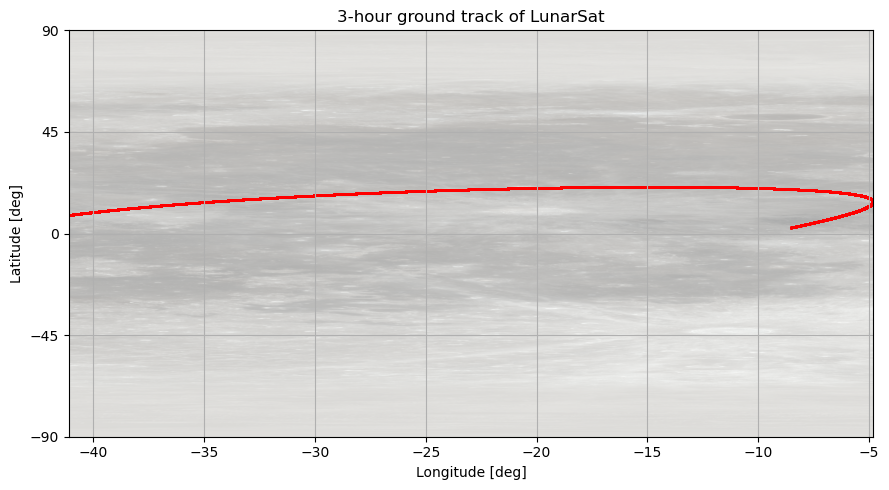

In [40]:

time_hours = dep_vars_array[:, 0] / 3600
total_acceleration_norm = np.linalg.norm(dep_vars_array[:, 1:4], axis=1)
latitude = dep_vars_array[:, 10]
longitude = dep_vars_array[:, 11]
hours = 4.15
subset = int(len(time_hours) / 24 * hours)
latitude = np.rad2deg(latitude[0:subset])
longitude = np.rad2deg(longitude[0:subset])

# Create a figure and axes
fig, ax = plt.subplots(figsize=(9, 5))

# Plot the image as the background
ax.imshow(background_image, extent=[-180,180, -90, 90], aspect='auto', alpha=0.4)

# Plot the ground track
ax.scatter(longitude, latitude, s=1, color='red')

# Customize the plot
plt.title("3-hour ground track of LunarSat")
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
plt.xlim([min(longitude), max(longitude)])
plt.yticks(np.arange(-90, 91, step=45))
plt.grid()

plt.tight_layout()

# Display the plot
plt.show()

In [41]:
print(latitude)
print(longitude)
len(latitude)

[ 2.64024074  2.65177329  2.6632909   2.6747936   2.68628141  2.69775437
  2.70921252  2.72065588  2.73208449  2.74349839  2.75489759  2.76628214
  2.77765206  2.7890074   2.80034817  2.81167442  2.82298617  2.83428346
  2.84556631  2.85683477  2.86808885  2.87932859  2.89055402  2.90176518
  2.91296209  2.92414479  2.9353133   2.94646765  2.95760788  2.96873402
  2.9798461   2.99094414  3.00202818  3.01309825  3.02415437  3.03519658
  3.04622491  3.05723938  3.06824003  3.07922689  3.09019998  3.10115933
  3.11210498  3.12303695  3.13395527  3.14485997  3.15575109  3.16662864
  3.17749265  3.18834317  3.19918021  3.2100038   3.22081397  3.23161075
  3.24239416  3.25316425  3.26392102  3.27466452  3.28539477  3.2961118
  3.30681563  3.31750629  3.32818381  3.33884822  3.34949955  3.36013781
  3.37076305  3.38137529  3.39197454  3.40256085  3.41313424  3.42369472
  3.43424235  3.44477712  3.45529909  3.46580826  3.47630467  3.48678834
  3.49725931  3.50771759  3.51816321  3.5285962   3.

[ -8.53035781  -8.52481507  -8.51928129  -8.51375646  -8.50824056
  -8.50273356  -8.49723546  -8.49174622  -8.48626583  -8.48079427
  -8.47533152  -8.46987755  -8.46443236  -8.45899591  -8.4535682
  -8.44814919  -8.44273888  -8.43733724  -8.43194425  -8.42655989
  -8.42118415  -8.41581701  -8.41045844  -8.40510843  -8.39976695
  -8.394434    -8.38910955  -8.38379358  -8.37848607  -8.37318701
  -8.36789637  -8.36261414  -8.3573403   -8.35207483  -8.34681772
  -8.34156893  -8.33632847  -8.3310963   -8.32587241  -8.32065679
  -8.31544941  -8.31025025  -8.3050593   -8.29987655  -8.29470196
  -8.28953553  -8.28437724  -8.27922707  -8.274085    -8.26895101
  -8.26382509  -8.25870722  -8.25359739  -8.24849556  -8.24340174
  -8.2383159   -8.23323802  -8.22816809  -8.22310609  -8.218052
  -8.2130058   -8.20796749  -8.20293704  -8.19791443  -8.19289965
  -8.18789269  -8.18289352  -8.17790213  -8.1729185   -8.16794261
  -8.16297446  -8.15801402  -8.15306128  -8.14811622  -8.14317882
  -8.13824907

44820

In [42]:
CoordinateMap = np.zeros(( 180*2+1,360*2+1))

In [43]:
lat0 = np.round((latitude + 90)/180*10800/30).astype(int)
lon0 = np.round((longitude +180)/360*21600/30).astype(int)

In [44]:
print(lat0)
print(lon0)
CoordinateMap.shape

[185 185 185 185 185 185 185 185 185 185 186 186 186 186 186 186 186 186
 186 186 186 186 186 186 186 186 186 186 186 186 186 186 186 186 186 186
 186 186 186 186 186 186 186 186 186 186 186 186 186 186 186 186 186 186
 186 187 187 187 187 187 187 187 187 187 187 187 187 187 187 187 187 187
 187 187 187 187 187 187 187 187 187 187 187 187 187 187 187 187 187 187
 187 187 187 187 187 187 187 187 187 187 187 187 187 188 188 188 188 188
 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188
 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188
 188 188 188 188 188 188 188 188 188 188 189 189 189 189 189 189 189 189
 189 189 189 189 189 189 189 189 189 189 189 189 189 189 189 189 189 189
 189 189 189 189 189 189 189 189 189 189 189 189 189 189 189 189 189 189
 189 189 189 189 189 189 189 189 189 190 190 190 190 190 190 190 190 190
 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190
 190 190 190 190 190 190 190 190 190 190 190 190 19

[343 343 343 343 343 343 343 343 343 343 343 343 343 343 343 343 343 343
 343 343 343 343 343 343 343 343 343 343 343 343 343 343 343 343 343 343
 343 343 343 343 343 343 343 343 343 343 343 343 343 343 343 343 343 344
 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344
 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344
 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344
 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344
 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344
 344 344 344 344 344 344 344 344 344 344 344 344 344 344 344 345 345 345
 345 345 345 345 345 345 345 345 345 345 345 345 345 345 345 345 345 345
 345 345 345 345 345 345 345 345 345 345 345 345 345 345 345 345 345 345
 345 345 345 345 345 345 345 345 345 345 345 345 345 345 345 345 345 345
 345 345 345 345 345 345 345 345 345 345 345 345 345 345 345 345 345 345
 345 345 345 345 345 345 345 345 345 345 345 345 34

(361, 721)

In [45]:
#indices = np.where(lon0==360)
#lon0 = np.delete(lon0,indices)
#lat0 = np.delete(lat0,indices)


In [46]:
np.set_printoptions(threshold=np.inf)

In [47]:
CoordinateMap[lat0,lon0] = 1

In [48]:
import numpy as np
from scipy.ndimage import convolve

def add_radius_around_ones(arr, radius):
    kernel = np.ones((2 * radius + 1, 2 * radius + 1))
    convolved = convolve(arr, kernel, mode='constant', cval=0)
    new_arr = np.where(convolved >= 1, 1, 0)
    return new_arr


radius = 6
new_map = add_radius_around_ones(CoordinateMap, radius)

print("Original Map:")
print(map)
print("\nNew Map:")
print(new_map)

Original Map:
<class 'map'>

New Map:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [49]:
import numpy as np
from scipy.ndimage import convolve

def add_radius_around_ones(arr, radius):
    kernel = np.ones((2 * radius + 1, 2 * radius + 1))
    convolved = convolve(arr, kernel, mode='constant', cval=0)
    new_arr = np.where(convolved >= 1, 1, 0)
    return new_arr


radius = 6
new_map2 = add_radius_around_ones(CoordinateMap, radius)

print("Original Map:")
print(map)
print("\nNew Map:")
print(new_map2)

Original Map:
<class 'map'>

New Map:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


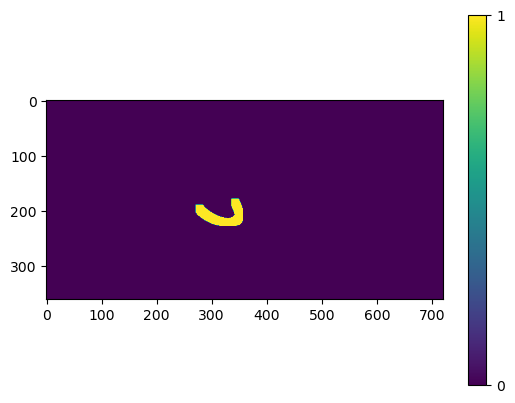

In [50]:
# Assuming you have the 'map' array from the previous code

plt.imshow(new_map+new_map2, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(ticks=[0, 1])
plt.show()

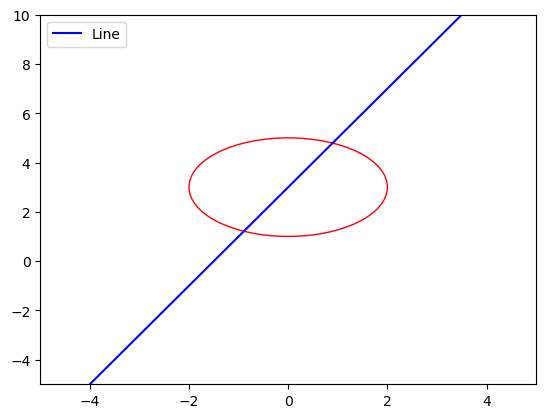

In [51]:
# Generate some example data
x = np.linspace(-5, 5, 100)
y = 2 * x + 3

# Create the plot
fig, ax = plt.subplots()

# Plot the line
ax.plot(x, y, 'b-', label='Line')

# Define the center and radius of the circular range
center = (0, 3)  # (x, y)
radius = 2

# Create the circle patch
circle = plt.Circle(center, radius, color='r', fill=False)

# Add the circle to the plot
ax.add_artist(circle)

# Set plot limits
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 10)

# Add a legend
ax.legend()

# Show the plot
plt.show()

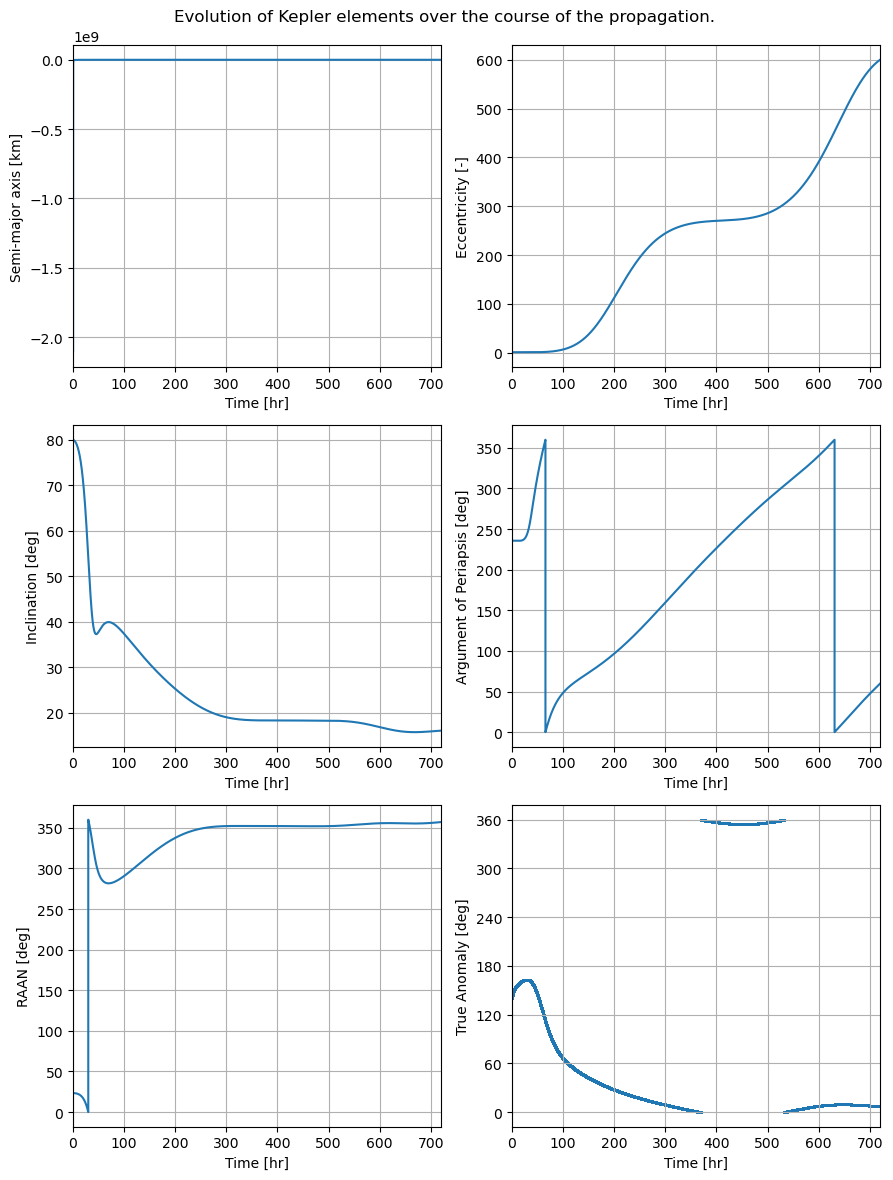

In [52]:
# Plot Kepler elements as a function of time
kepler_elements = dep_vars_array[:,4:10]
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(9, 12))
fig.suptitle('Evolution of Kepler elements over the course of the propagation.')

# Semi-major Axis
semi_major_axis = kepler_elements[:,0] / 1e3
ax1.plot(time_hours, semi_major_axis)
ax1.set_ylabel('Semi-major axis [km]')

# Eccentricity
eccentricity = kepler_elements[:,1]
ax2.plot(time_hours, eccentricity)
ax2.set_ylabel('Eccentricity [-]')

# Inclination
inclination = np.rad2deg(kepler_elements[:,2])
ax3.plot(time_hours, inclination)
ax3.set_ylabel('Inclination [deg]')

# Argument of Periapsis
argument_of_periapsis = np.rad2deg(kepler_elements[:,3])
ax4.plot(time_hours, argument_of_periapsis)
ax4.set_ylabel('Argument of Periapsis [deg]')

# Right Ascension of the Ascending Node
raan = np.rad2deg(kepler_elements[:,4])
ax5.plot(time_hours, raan)
ax5.set_ylabel('RAAN [deg]')

# True Anomaly
true_anomaly = np.rad2deg(kepler_elements[:,5])
ax6.scatter(time_hours, true_anomaly, s=1)
ax6.set_ylabel('True Anomaly [deg]')
ax6.set_yticks(np.arange(0, 361, step=60))

for ax in fig.get_axes():
    ax.set_xlabel('Time [hr]')
    ax.set_xlim([min(time_hours), max(time_hours)])
    ax.grid()
plt.tight_layout()

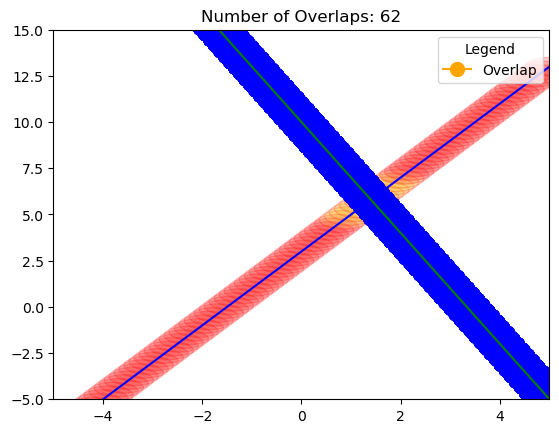

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

# Generate some example data
x = np.linspace(-5, 5, 100)
y1 = 2 * x + 3
y2 = -3 * x + 10

# Create the plot
fig, ax = plt.subplots()

# Plot the lines
line1, = ax.plot(x, y1, 'b-', label='Line 1')
line2, = ax.plot(x, y2, 'g-', label='Line 2')

# Define the radius and alpha (transparency) of the circles
radius = 0.5
alpha = 0.2

# Initialize overlap counter
overlaps = 0

# Add circles around Line 1
for i in range(len(x)):
    center = (x[i], y1[i])
    circle1 = Circle(center, radius, color='r', alpha=alpha)

    # Add circles around Line 2
    for j in range(len(x)):
        center2 = (x[j], y2[j])
        circle2 = Circle(center2, radius, color='b', alpha=alpha)

        # Check if the circles intersect
        if np.linalg.norm(np.array(center) - np.array(center2)) <= 2 * radius:
            circle1.set_facecolor('orange')  # Set different color for intersection
            circle2.set_facecolor('orange')  # Set different color for intersection
            overlaps += 1

        ax.add_patch(circle2)

    ax.add_patch(circle1)

# Set plot limits
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 15)

# Add legend with overlap count
legend_elements = [
    Line2D([], [], marker='o', markersize=10, color='orange', label='Overlap')
]
ax.legend(handles=legend_elements, loc='upper right', title='Legend')
ax.set_title(f'Number of Overlaps: {overlaps}')

# Show the plot
plt.show()


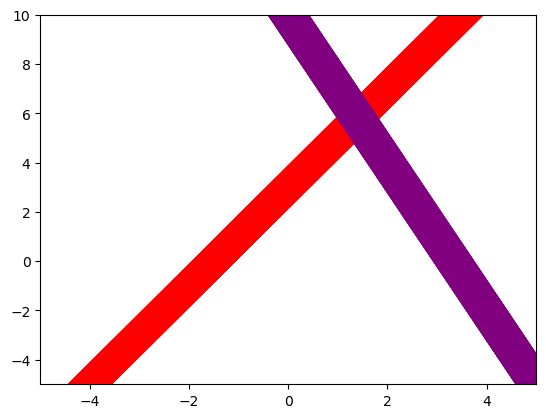

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some example data
x = np.linspace(-5, 5, 1000)
y1 = 2 * x + 3
y2 = -3 * x + 10

# Create the plot
fig, ax = plt.subplots()



# Define the radius of the circular range
radius = 0.4
alpha = 1

# Add circles at different points along the line
for i in range(len(x)):
    center = (x[i], y1[i])
    circle = plt.Circle(center, radius, facecolor='r',alpha=alpha, fill=True,edgecolor = 'none')
    ax.add_artist(circle)
    
for i in range(len(x)):
    center = (x[i], y2[i])
    circle = plt.Circle(center, radius, facecolor='purple',alpha=alpha, fill=True, edgecolor = 'none')
    ax.add_artist(circle)
    
    
    

# Set plot limits
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 10)

# Add a legend


# Show the plot
plt.show()